In [175]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pairs = [['IEMG', 'EEM'], ['ARKK', 'ARKW'], ['TLT', 'SPTL'], ['SHY', 'VGSH'], ['SOXX', 'ITA']]

downloadable_tickers = [ticker for pair in pairs for ticker in pair]

training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2024-12-31')['Close']

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_61048/3707875857.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
[*********************100%***********************]  10 of 10 completed
/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_61048/3707875857.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2024-12-31')['Close']
[*********************100%***********************]  10 of 10 completed


In [176]:
def zscore_calc(series):
    return (series - series.mean()) / series.std()

In [177]:
training_spreads = {}
testing_spreads = {}

for etf1, etf2 in pairs:
    train_z1, train_z2 = zscore_calc(training_data[etf1]), zscore_calc(training_data[etf2])

    test_z1, test_z2 = zscore_calc(testing_data[etf1]), zscore_calc(testing_data[etf2])

    training_spread, testing_spread = train_z1 - train_z2, test_z1 - test_z2
    training_spreads[f'{etf1}_{etf2}'], testing_spreads[f'{etf1}_{etf2}'] = training_spread, testing_spread

training_spreads_df = pd.DataFrame(training_spreads)
testing_spreads_df = pd.DataFrame(testing_spreads)

In [178]:
def create_sequences(data, window_size):
    X, y  = [], []

    for i in range(len(data) - window_size):
        X.append(data.iloc[i : i + window_size])
        y.append(data.iloc[i + window_size])

        X_1 = np.array(X)
        y_1 = np.array(y)

    return torch.tensor(X_1, dtype = torch.float32), torch.tensor(y_1, dtype = torch.float32)

In [179]:
X_train, y_train = create_sequences(training_spreads_df['IEMG_EEM'], window_size = 30)
X_test, y_test = create_sequences(testing_spreads_df['IEMG_EEM'], window_size = 30)

In [180]:
class SpreadLSTM(nn.Module):
    def __init__(self, input_size = 1,  hidden_size = 1, num_layers = 1):
        super(SpreadLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.linear(out)
        return out

In [181]:
train_dataset = TensorDataset(X_train.unsqueeze(-1), y_train.unsqueeze(-1))
test_dataset = TensorDataset(X_test.unsqueeze(-1), y_test.unsqueeze(-1))

train_loader = DataLoader(train_dataset, batch_size = 64)
test_loader = DataLoader(test_dataset, batch_size = 64)

In [182]:
device = torch.device('cpu')
model = SpreadLSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

epochs = 50
model.train()

for epoch in range(epochs):
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")
    

Epoch 1/50 - Loss: 0.0010
Epoch 2/50 - Loss: 0.0007
Epoch 3/50 - Loss: 0.0007
Epoch 4/50 - Loss: 0.0007
Epoch 5/50 - Loss: 0.0007
Epoch 6/50 - Loss: 0.0007
Epoch 7/50 - Loss: 0.0007
Epoch 8/50 - Loss: 0.0007
Epoch 9/50 - Loss: 0.0007
Epoch 10/50 - Loss: 0.0007
Epoch 11/50 - Loss: 0.0007
Epoch 12/50 - Loss: 0.0007
Epoch 13/50 - Loss: 0.0007
Epoch 14/50 - Loss: 0.0007
Epoch 15/50 - Loss: 0.0007
Epoch 16/50 - Loss: 0.0007
Epoch 17/50 - Loss: 0.0007
Epoch 18/50 - Loss: 0.0007
Epoch 19/50 - Loss: 0.0007
Epoch 20/50 - Loss: 0.0007
Epoch 21/50 - Loss: 0.0007
Epoch 22/50 - Loss: 0.0007
Epoch 23/50 - Loss: 0.0007
Epoch 24/50 - Loss: 0.0007
Epoch 25/50 - Loss: 0.0007
Epoch 26/50 - Loss: 0.0007
Epoch 27/50 - Loss: 0.0007
Epoch 28/50 - Loss: 0.0007
Epoch 29/50 - Loss: 0.0007
Epoch 30/50 - Loss: 0.0007
Epoch 31/50 - Loss: 0.0007
Epoch 32/50 - Loss: 0.0007
Epoch 33/50 - Loss: 0.0007
Epoch 34/50 - Loss: 0.0007
Epoch 35/50 - Loss: 0.0007
Epoch 36/50 - Loss: 0.0007
Epoch 37/50 - Loss: 0.0007
Epoch 38/5

In [183]:
model.eval()
test_loss = 0
preds = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        preds.append(pred.cpu())
        loss = criterion(pred, yb)
        test_loss += loss.item()

print(f"Test Loss: {test_loss/len(test_loader):.4f}")

Test Loss: 0.0425


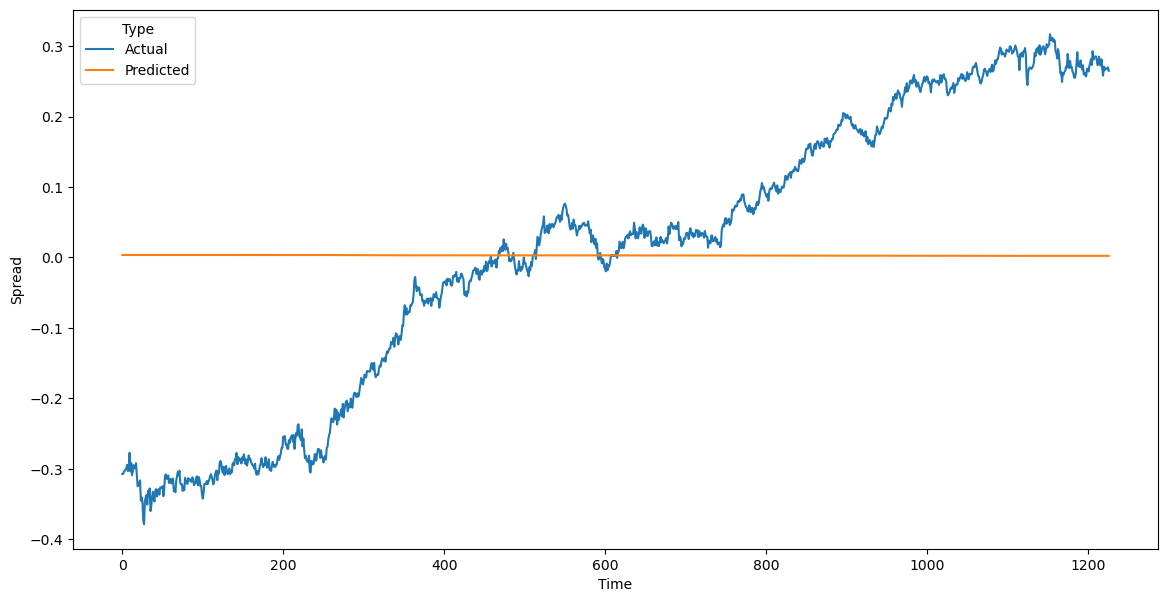

In [184]:
y_pred = torch.cat(preds).numpy()

y_pred_np = y_pred.flatten()
y_test_np = y_test.cpu().numpy().flatten()

plot_df = pd.DataFrame({
    'Time': range(len(y_test_np)),
    'Actual': y_test_np,
    'Predicted': y_pred_np
})

plot_df = plot_df.melt(id_vars = 'Time', value_vars = ['Actual', 'Predicted'], var_name = 'Type', value_name = 'Spread')

plt.subplots(figsize = (14, 7))

sns.lineplot(data = plot_df, x = 'Time', y = 'Spread', hue = 'Type')
plt.show()